In [1]:
%load_ext autoreload
%autoreload 2

In [177]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw
from scipy.cluster.hierarchy import DisjointSet

import networkx as nx

from minimal.imaging import blit_rooms, draw_sep_nask_wireframe
from minimal.layout import NodeType, NODE_COLOR
from minimal.gen import PlanMasks
from minimal.rooms import RoomAreas, extract_rooms
from minimal.rooms import create_room_mask, create_inv_room_mask, scale_room_mask
from minimal.walls import create_sep_mask, scale_sep_mask, _conv_mask
from minimal.doors import extract_face_walls, candidate_wall_runs
from minimal.doors import select_rooms_to_join, create_doors

%matplotlib inline

In [25]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_02.pth"))
rooms = extract_rooms(pm)
rooms.sort(key=lambda r: r.total_area())
# blit_rooms(rooms)

CPU times: user 939 ms, sys: 0 ns, total: 939 ms
Wall time: 938 ms


In [139]:
%%time

# 1-based index
rooms_to_join = select_rooms_to_join(rooms, pm.graph)
rooms_to_join

CPU times: user 414 µs, sys: 34 µs, total: 448 µs
Wall time: 458 µs


[(7, 4), (8, 4), (9, 3), (8, 1), (9, 5), (8, 6), (9, 7), (5, 2)]

In [175]:
room_mask = create_room_mask(rooms)
sep_mask = create_sep_mask(room_mask)

sx = 3
sy = 3

sep_mask = scale_sep_mask(sep_mask, sx, sy)
room_mask = scale_room_mask(room_mask, sx, sy)

In [244]:
doors = create_doors(len(rooms), rooms_to_join, room_mask, sep_mask)
print(doors)

[(146, 144, 4, 'h'), (158, 113, 4, 'v'), (69, 108, 4, 'h'), (167, 79, 4, 'h'), (69, 67, 4, 'h'), (117, 94, 4, 'h'), (104, 149, 4, 'h'), (27, 46, 4, 'h')]


In [246]:
walls = (sep_mask > 0).byte()
for (x1,y1,l,o) in doors:
    x2, y2 = x1 + 1, y1 + 1
    if o == 'h':
        y2 = y1 + l
    else:
        x2 = x1 + l

    walls[x1:x2, y1:y2] = 0

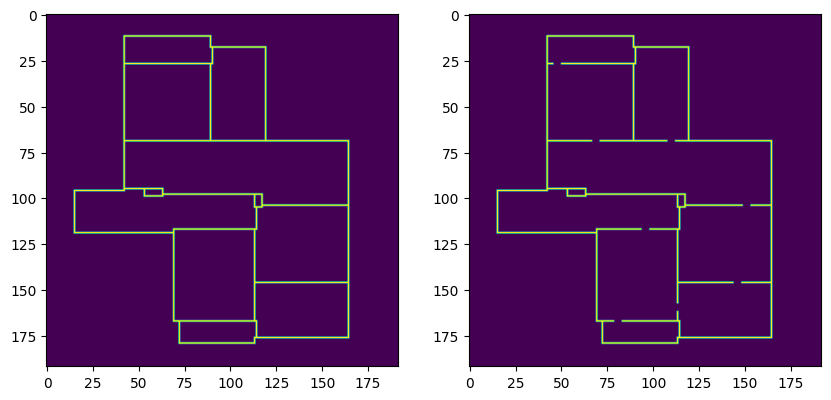

In [250]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(sep_mask > 0)

plt.subplot(122)
plt.imshow(walls)